# ABC calibration of $I_\text{CaL}$ in Courtemanche model to unified dataset.

In [2]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [4]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments for unified dataset:
 - Steady-state activation [Li1997]
 - Activation time constant [Li1997]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant [Sun1997]
 - Recovery time constant [Li1997]

In [5]:
from experiments.ical_li import (li_act_and_tau,
                                 li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

In [6]:
modelfile = 'models/courtemanche_ical.mmt'

Plot steady-state and tau functions

In [7]:
from ionchannelABC.visualization import plot_variables

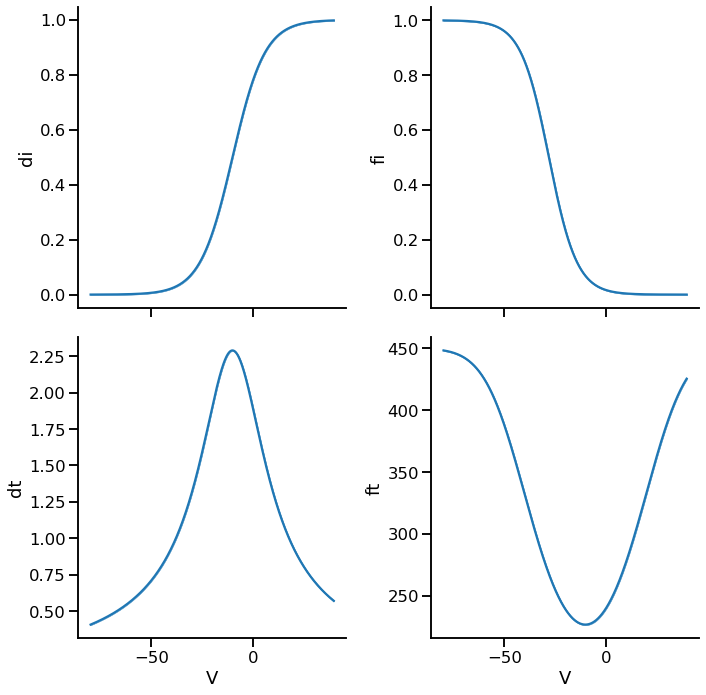

In [8]:
sns.set_context('talk')

V = np.arange(-80, 40, 0.01)

cou_par_map = {'di': 'ical.d_inf',
            'fi': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'ft': 'ical.tau_f'}

f, ax = plot_variables(V, cou_par_map, 'models/courtemanche_ical.mmt', figshape=(2,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                li_act_and_tau)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

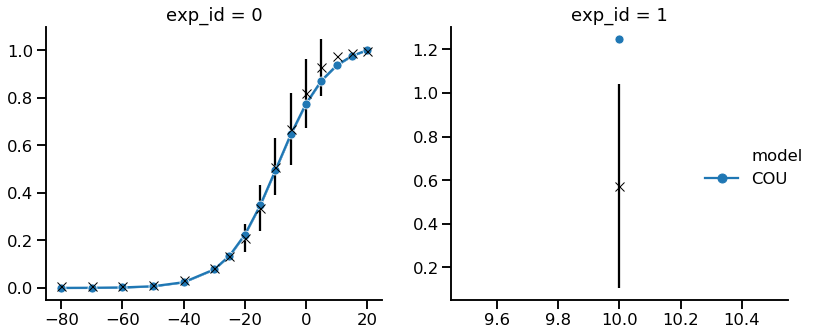

In [10]:
g = plot_sim_results(modelfile,
                     li_act_and_tau)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [11]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [12]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [13]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ical_dgate_unified.db"))

In [14]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [15]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32 particles


In [16]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.2287454676498424, '1': 1.2287454676498424, '2': 1.2287454676498424, '3': 1.2287454676498424, '4': 1.2287454676498424, '5': 1.2287454676498424, '6': 1.2287454676498424, '7': 1.0293830767146164, '8': 0.6283247351374927, '9': 0.5133263088125923, '10': 0.4040167399213943, '11': 0.41888315675832816, '12': 0.5146915383573082, '13': 1.2287454676498424, '14': 1.2287454676498424, '15': 1.2287454676498424, '16': 1.2039197677998432}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [17]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [18]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-12-20 07:36:25.341169, end_time=None)>


In [19]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.
DEBUG:ABC:Population 0 done.
DEBUG:ABC:Total samples up to t = 0: 1376.
INFO:ABC:Acceptance rate: 1000 / 1376 = 7.2674e-01.
DEBUG:Epsilon:new eps, t=1, eps=2.2207789917955436
INFO:ABC:t: 1, eps: 2.2207789917955436.
DEBUG:ABC:Now submitting population 1.
DEBUG:ABC:Population 1 done.
DEBUG:ABC:Total samples up to t = 1: 3307.
INFO:ABC:Acceptance rate: 1000 / 1931 = 5.1787e-01.
DEBUG:Epsilon:new eps, t=2, eps=1.4282573040999804
INFO:ABC:t: 2, eps: 1.4282573040999804.
DEBUG:ABC:Now submitting population 2.
DEBUG:ABC:Population 2 done.
DEBUG:ABC:Total samples up to t = 2: 5427.
INFO:ABC:Acceptance rate: 1000 / 2120 = 4.7170e-01.
DEBUG:Epsilon:new eps, t=3, eps=1.292103956052412
INFO:ABC:t: 3, eps: 1.292103956052412.
DEBUG:ABC:Now submitting population 3.
DEBUG:ABC:Population 3 done.
DEBUG:ABC:Total samples up to t = 3: 7949.
INFO:ABC:Acceptance rate: 1000 / 2522 = 3.9651e-01.
DEBUG:Epsilon:new eps, t=4, eps=1.1523951468754736
I

### Analysis of results

In [22]:
df, w = history.get_distribution(m=0)

In [23]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-55.456006,12.188599,10.311932,7.492075,-1.450409
std,20.599434,10.602261,0.204818,0.109751,0.227195
min,-99.985450,0.170767,9.520564,7.218237,-1.869195
25%,-71.157241,4.119229,10.223532,7.415439,-1.628989
50%,-53.611204,9.019055,10.351252,7.484404,-1.483651
75%,-38.379680,17.492310,10.453144,7.551744,-1.289556
max,24.102362,49.748571,10.988258,8.076213,-0.652669


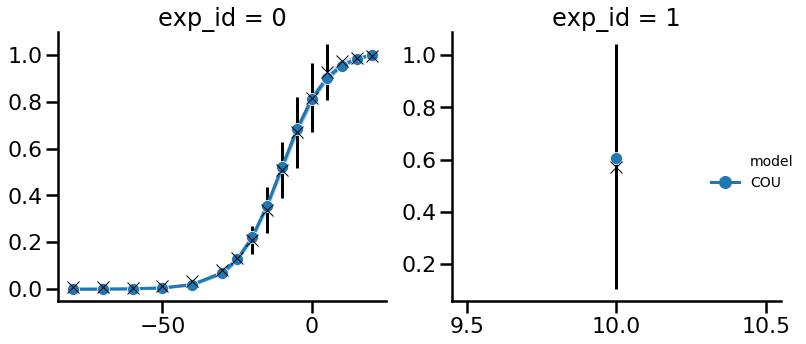

In [24]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_act_and_tau,
                     df=df, w=w)

plt.tight_layout()

In [25]:
m,_,_ = myokit.load(modelfile)

In [26]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

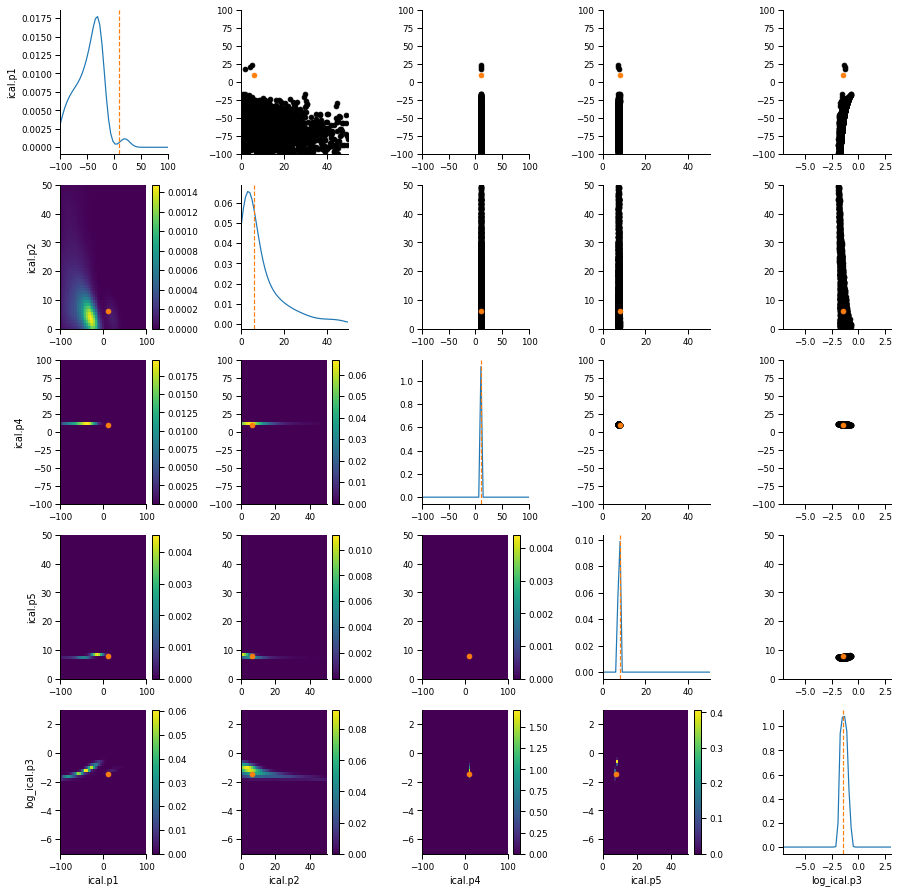

In [27]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

In [28]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

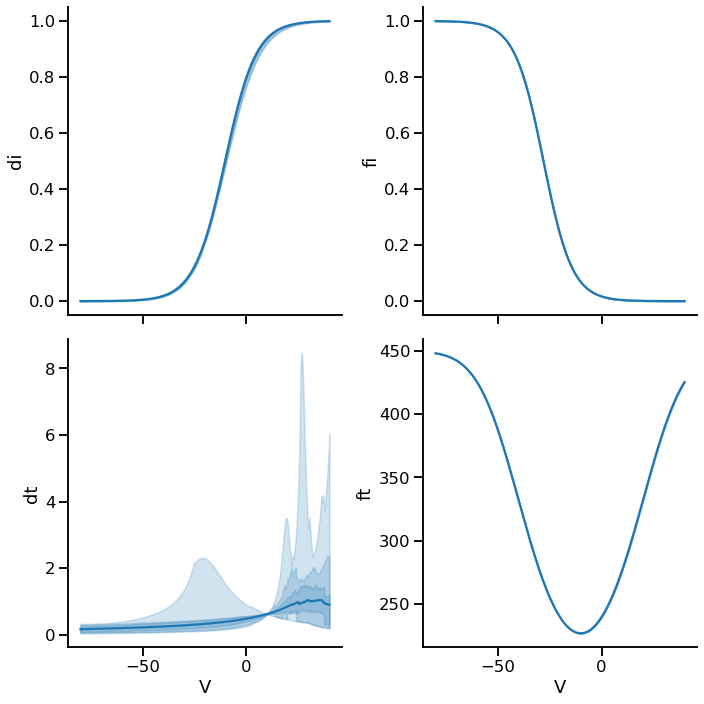

In [29]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-80, 40, 0.01)

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ical.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))

# Voltage-dependent inactivation gate ($f$) calibration

In [9]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [10]:
assert len(observations)==len(summary_statistics(model({})))

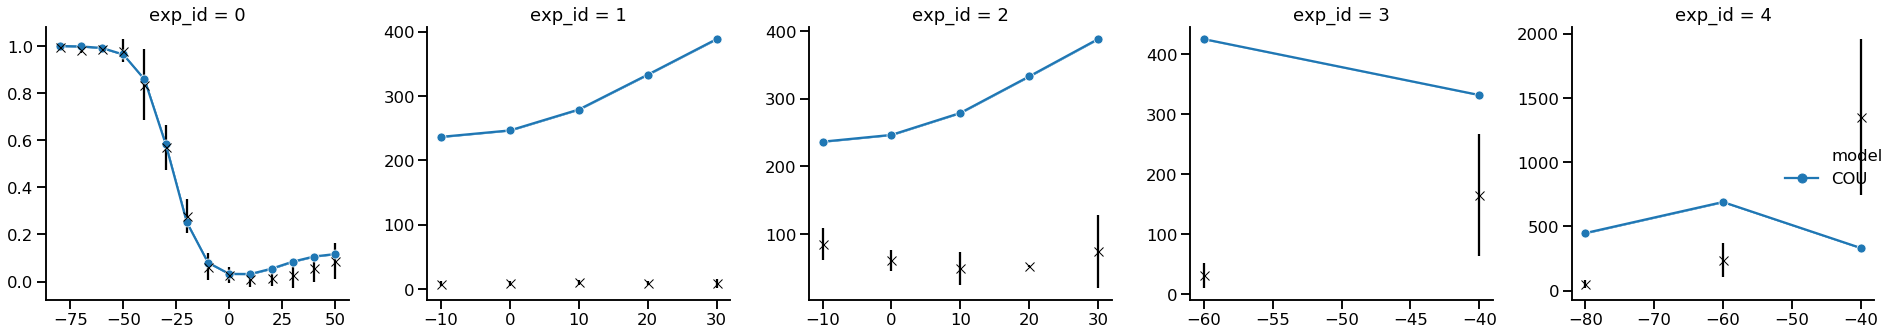

In [11]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [12]:
limits = {'log_ical.q1': (0, 3),
          'log_ical.q2': (-2, 3),
          'log_ical.q3': (-4, 0),
          'ical.q4': (-100, 100),
          'log_ical.q5': (-4, 0),
          'ical.q6': (-100, 100),
          'ical.q7': (0, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [13]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [14]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "courtemanche_ical_fgate_unified.db"))

In [15]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [16]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [17]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810967, '1': 0.9837148289810967, '2': 0.9837148289810967, '3': 0.9837148289810967, '4': 0.3255918060516033, '5': 0.5055241199222262, '6': 0.6753486289586007, '7': 0.8392681990941822, '8': 0.9837148289810967, '9': 0.9837148289810967, '10': 0.9837148289810967, '11': 0.9196236649649016, '12': 0.8392681990941822, '13': 0.6309826606328519, '14': 0.46084783444382477, '15': 0.4184561967200059, '16': 0.36886776090803813, '17': 0.4191992497796024, '18': 0.21952975590454923, '19': 0.5102122707484875, '20': 0.7659862673065291, '21': 0.4791367008919785, '22': 2.754401521147071, '23': 0.21885528270246793, '24': 2.749064693405502, '25': 0.5560031468540614, '26': 4.590669201911785, '27': 2.354305935366494, '28': 0.5128531003233774}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [18]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [19]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-12-23 20:41:53.337473, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 100.
DEBUG:ABC:Now submitting population 0.


### Analysis of results

In [21]:
df, w = history.get_distribution()

In [22]:
df.describe()

name,ical.q4,ical.q6,ical.q7,log_ical.q1,log_ical.q2,log_ical.q3,log_ical.q5
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1.419296,32.947754,10.664789,0.709593,0.213061,-0.943831,-0.722909
std,1.705775,4.093951,1.839731,0.393100,0.446809,0.086242,0.392315
min,-2.295765,20.846965,5.849216,0.000581,-1.041084,-1.206466,-1.494250
25%,0.307098,29.920871,9.452986,0.366534,-0.133132,-0.992496,-1.068665
50%,1.213227,33.133337,10.849904,0.712800,0.216983,-0.929506,-0.721753
75%,2.220998,35.890635,11.955608,1.036415,0.569636,-0.880181,-0.390405
max,8.517182,46.246204,15.911257,1.503770,1.643090,-0.764826,-0.000500


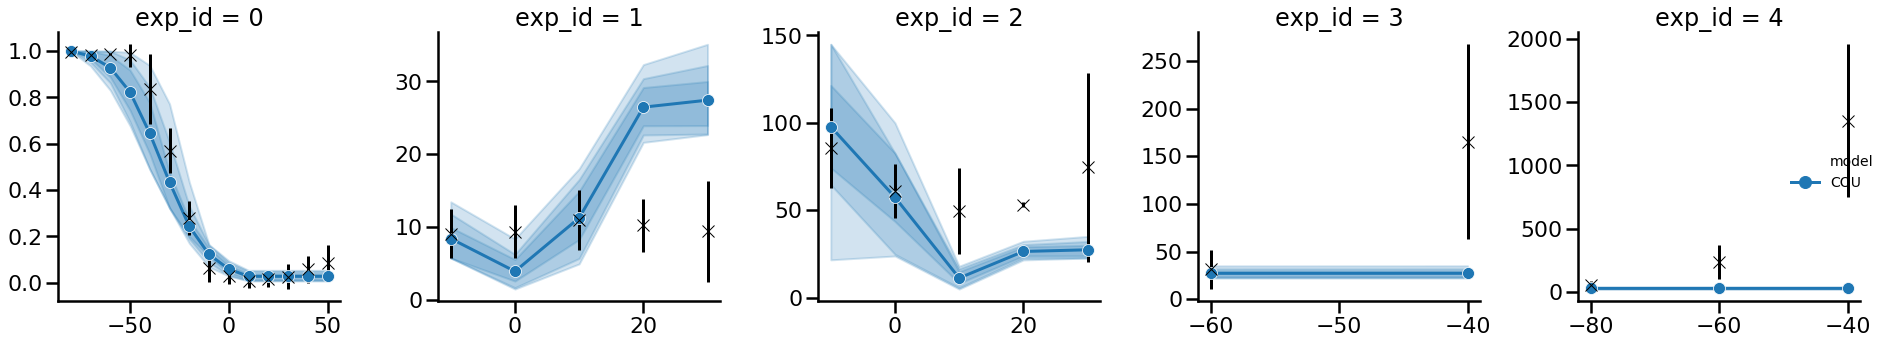

In [23]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

plt.tight_layout()

In [24]:
m,_,_ = myokit.load(modelfile)

In [25]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

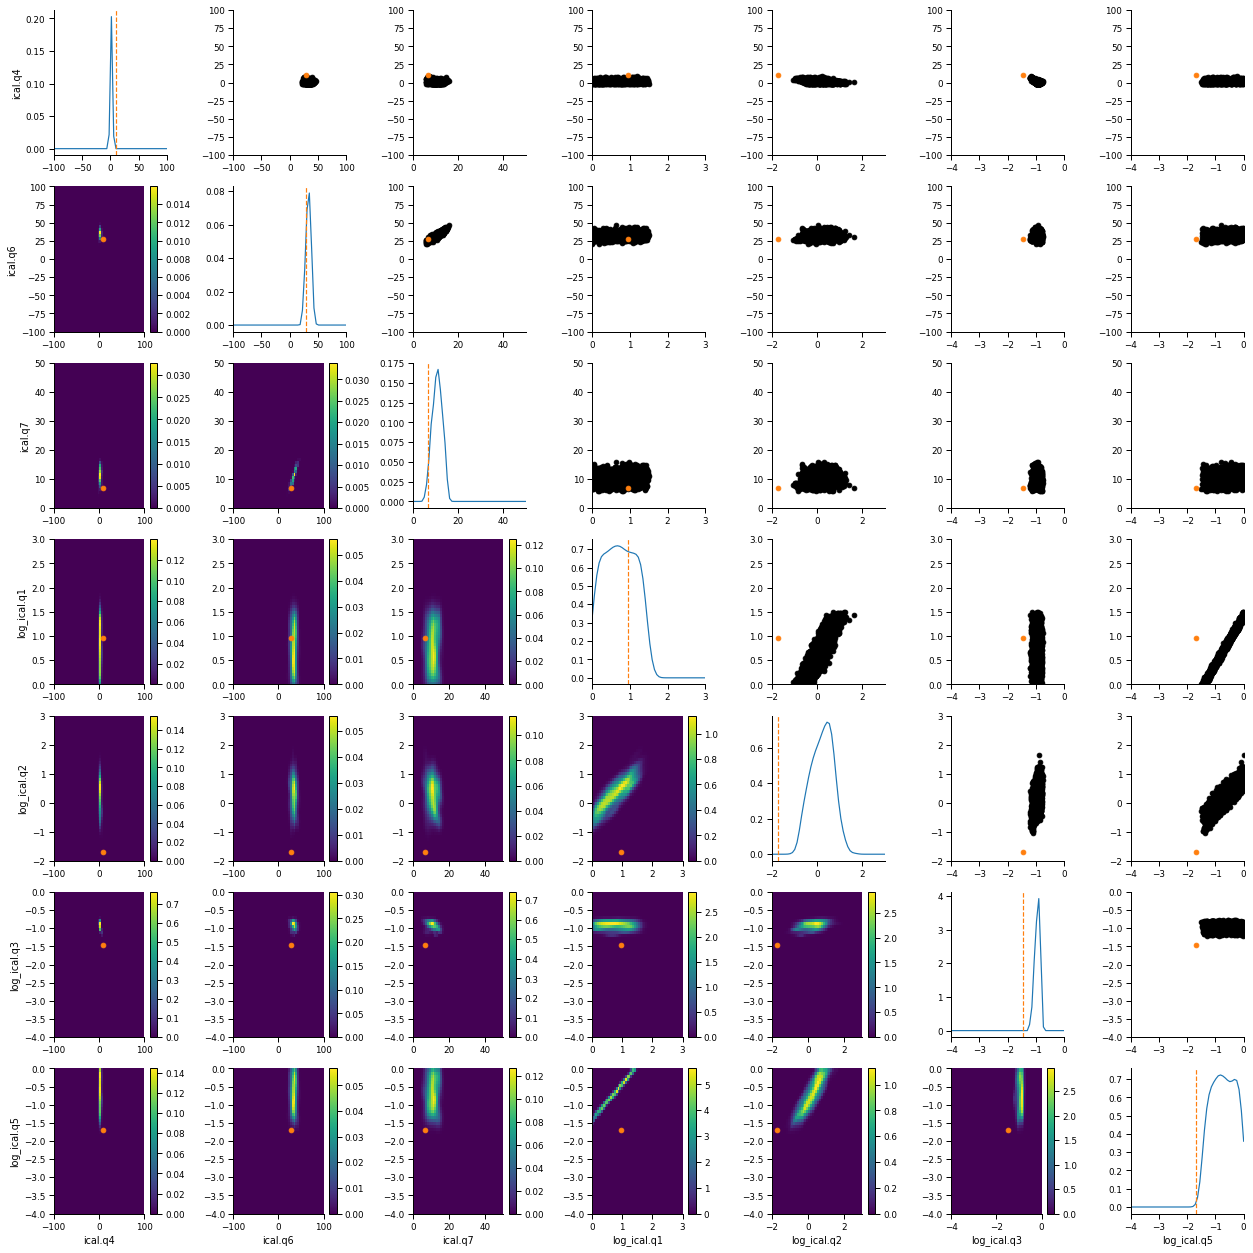

In [26]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)
plt.tight_layout()

In [29]:
import pandas as pd
N = 100
cou_par_samples = df.sample(n=N, weights=w, replace=True)
cou_par_samples = cou_par_samples.set_index([pd.Index(range(N))])
cou_par_samples = cou_par_samples.to_dict(orient='records')

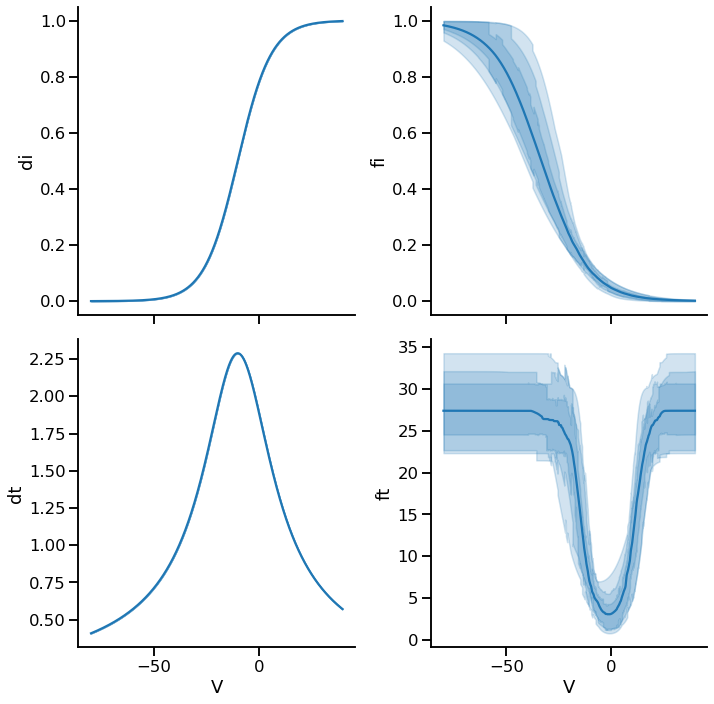

In [30]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14
V = np.arange(-80, 40, 0.01)

f, ax = plot_variables(V, cou_par_map, 
                       'models/courtemanche_ical.mmt', 
                       [cou_par_samples],
                       figshape=(2,2))